## Overview

Over the past week, sample MEG and EEG data were modeled based on different wavelet transformation, and the performance of each wavelet transformation was compared.  Performance was explored based on reconstruction of the data compressed in the wavelet basis.  Thus, we attempted to find wavelet transformations that resulted in a sparser set of coefficients in the wavelet basis.

## Data and Package Imports

Raw MNE data

In [1]:
import mne
from mne.datasets import sample
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.Raw(raw_fname, preload=True)

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pywt

Opening raw data file /anaconda/lib/python2.7/examples/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
Current compensation grade : 0
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
[done]


## Functions

The function below takes in a sample dataset and perform different wavelet decompositions and reconstruction, plot the reconstructed data on top of the original data, plot a histogram of the coefficients, and give an R2 statistic on the performance of the compression and reconstruction.
In order to evaluate the performance of a wavelet basis, a full wavelet decomposition was performed. Then the standard deviation of the detail coefficients was evaluated based on the median absolute deviation and a normal distribution assumption. Any detail coefficients below a specified number of standard deviations were set to zero. Finally, the signal was reconstructed with the new coefficients.  Consequently, we seek sparsity in coefficients; if many coefficients are close to zero in the wavelet basis, setting them to zero should have little effect on the reconstructed signal.

Function to calculate R^2 statistic

In [2]:
def r2stat(y, f):
    ybar = np.mean(y)
    sstot = np.sum((y - ybar)**2)
    ssres = np.sum((y - f)**2)
    return 1 - ssres / sstot

Function to do wavelet decomposition & reconstruction to a particular level

In [3]:
def getSDFromMAD(x):
    mad = np.median(abs(x-np.median(x)))
    return 1.4826*mad

Function to do wavelet decomposition & reconstruction to a particular level

In [4]:
def reconstruct(data, wavelet_type, level, num_sd):
    coefs = pywt.wavedec(data, wavelet_type, level=level)
    concatenated_coefs = np.concatenate(coefs)
    detail_coefs = coefs[1:]
    #Get median absolute deviation of detail coefficients
    detail_sd_approx = getSDFromMAD(np.concatenate(detail_coefs))
    num_detail_coefs = 0;
    num_zeroed = 0;
    if (len(coefs) > 1):
        for i in range(1,len(coefs)):
            for j in range(0,len(coefs[i])):
                num_detail_coefs += 1;
                if (abs(coefs[i][j]) < detail_sd_approx*num_sd):
                    coefs[i][j] = 0
                    num_zeroed += 1
    reconstructed = pywt.waverec(coefs, wavelet_type)
    return (reconstructed, concatenated_coefs, num_zeroed)

Function to plot reconstruction, histogram for wavelet coefs, performance

In [5]:
# data = original signal data
# time = time points of signal data
# wavelet_type = string specifying wavelet type in pywavelet package
# level = number of levels to deconstruct to in wavelet basis
# num_sd = specifies range of coefficients zeroes zeroed out by number of standard deviations
def getReconstructPlots(data, times, wavelet_type, level, num_sd):
    (reconstructed, concatenated_coefs, num_zeroed) = \
        reconstruct(data, wavelet_type, level, num_sd)
    reconstructed = reconstructed[0:len(times)]
    num_coefs = len(concatenated_coefs)
    print('Number detail coefficients zeroed: ' + str(num_zeroed) + ' out of ' + str(len(times)))
    r2_stat = r2stat(data, reconstructed)
    print('R2 stat: ' + str(r2_stat))
    plt.figure(figsize=(len(times)*.02,3))
    plt.plot(times, data)
    plt.plot(times, reconstructed)
    plt.figure()
    plt.hist(abs(concatenated_coefs), bins=40)

##Results

**Sample EEG data, 5 seconds**

In general, for EEG data, it seems that longer wavelets with more fluctuations performed better than shorter, simpler wavelets; for example, reconstruction of the signal using the daubechies wavelet with 9 taps had a better R2 statistic than using the daubechies wavelet with 2 taps.

In [7]:
eeg_channel_data = raw.pick_channels(['EEG 020'], copy=True)
start, stop = eeg_channel_data.time_as_index([50, 55])
data, times = eeg_channel_data[:, start:stop]
data = data[0,:]

Daubechies Wavelet, 2 taps

Number detail coefficients zeroed: 677 out of 751
R2 stat: 0.886284829214


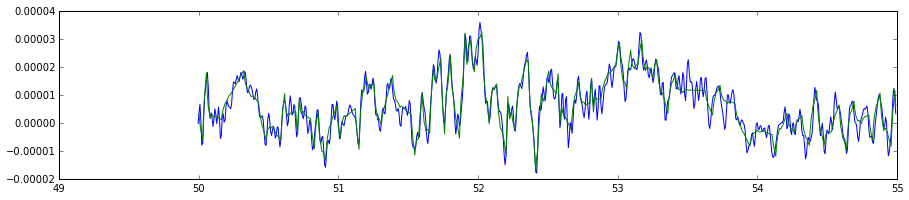

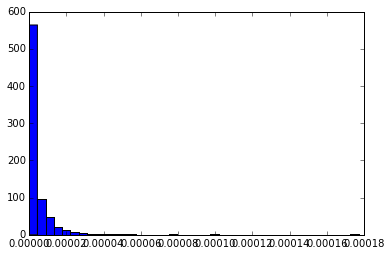

In [8]:
getReconstructPlots(data, times, 'db2', None, 3)

Daubechies Wavelet, 9 taps

Number detail coefficients zeroed: 655 out of 751
R2 stat: 0.942564300518


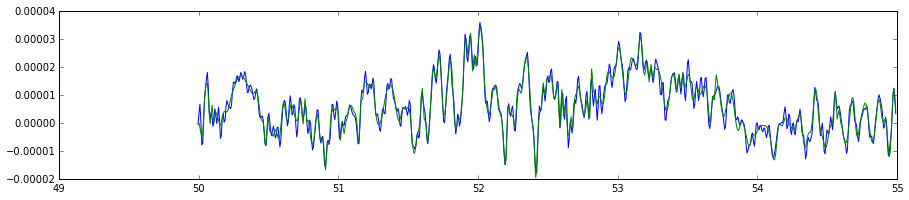

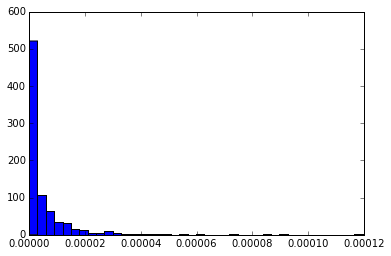

In [9]:
getReconstructPlots(data, times, 'db9', None, 3)

Haar Wavelet

Number detail coefficients zeroed: 684 out of 751
R2 stat: 0.813041329647


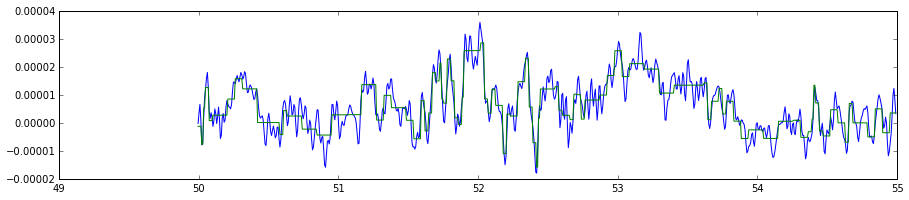

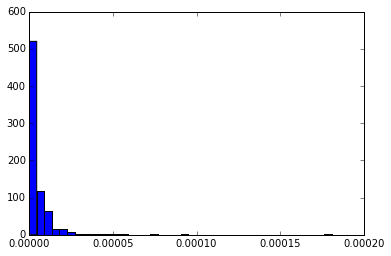

In [10]:
getReconstructPlots(data, times, 'haar', None, 3)

Biorthogonal Wavelet (1.3)

Number detail coefficients zeroed: 689 out of 751
R2 stat: 0.844483767781


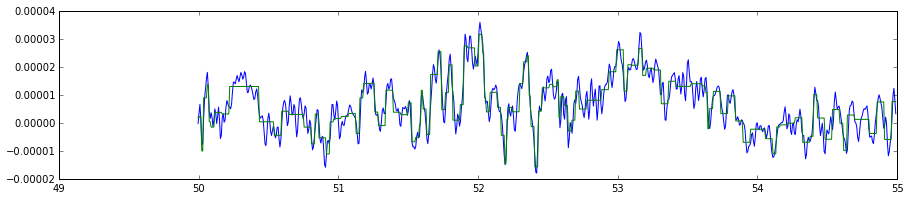

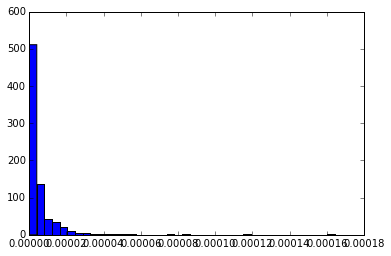

In [11]:
getReconstructPlots(data, times, 'bior1.3', None, 3)

Biorthogonal Wavelet (2.8)

Number detail coefficients zeroed: 641 out of 751
R2 stat: 0.948780817224


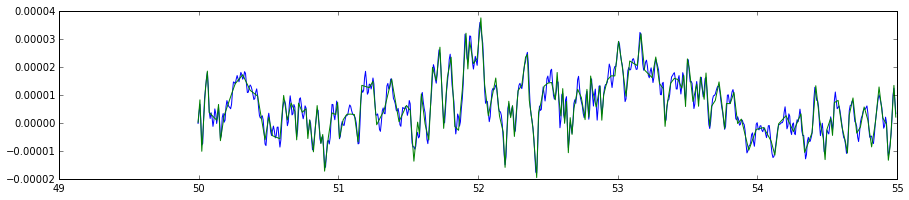

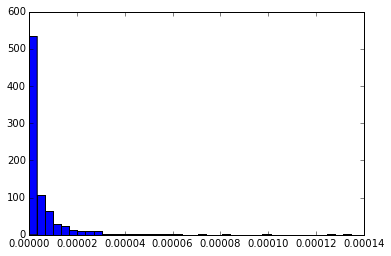

In [12]:
getReconstructPlots(data, times, 'bior2.8', None, 3)

**Sample MEG data, 5 seconds**

Similar performance characteristics were observed in MEG data, although the difference in the R2 statistic was less extreme

In [13]:
meg_channel_data = raw.pick_channels(['MEG 0113'], copy=True)
start, stop = meg_channel_data.time_as_index([50, 55])
data, times = meg_channel_data[:, start:stop]
data = data[0,:]

Daubechies Wavelet, 2 taps

Number detail coefficients zeroed: 668 out of 751
R2 stat: 0.869697456754


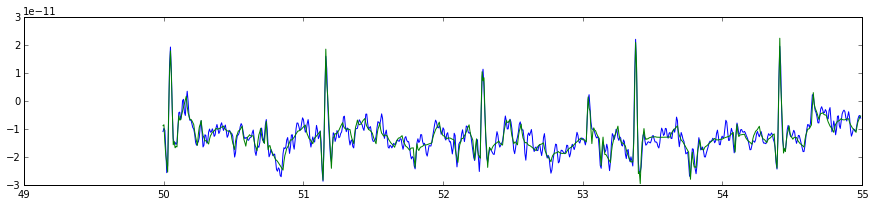

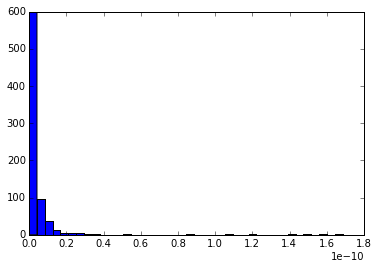

In [14]:
getReconstructPlots(data, times, 'db2', None, 3)

Daubechies Wavelet, 9 taps

Number detail coefficients zeroed: 663 out of 751
R2 stat: 0.907548446878


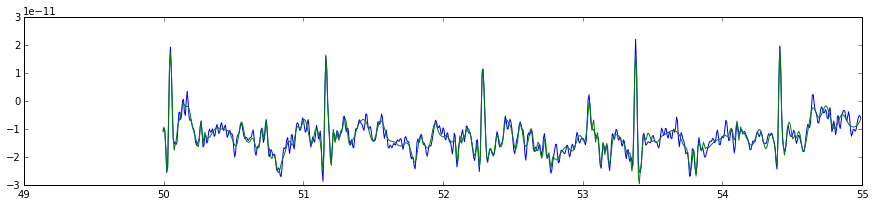

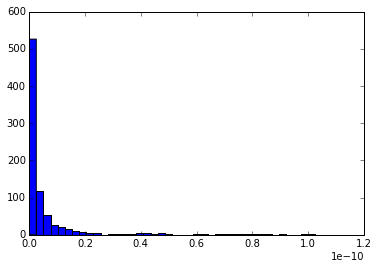

In [15]:
getReconstructPlots(data, times, 'db9', None, 3)

Haar Wavelet

Number detail coefficients zeroed: 668 out of 751
R2 stat: 0.837078242973


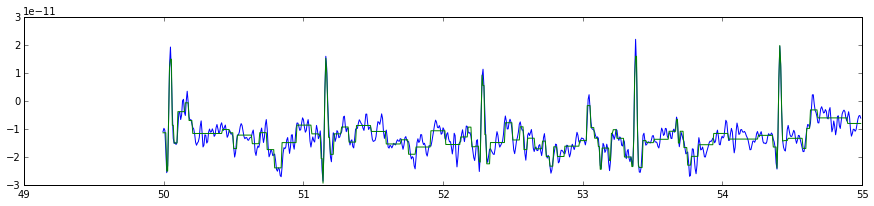

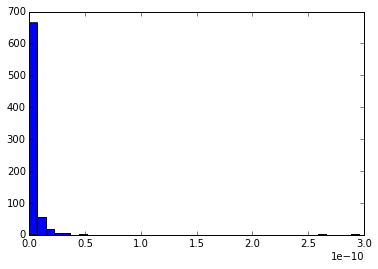

In [16]:
getReconstructPlots(data, times, 'haar', None, 3)

Biorthogonal Wavelet (1.3)

Number detail coefficients zeroed: 684 out of 751
R2 stat: 0.830562436523


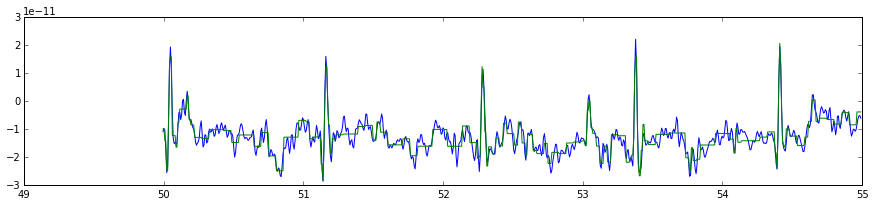

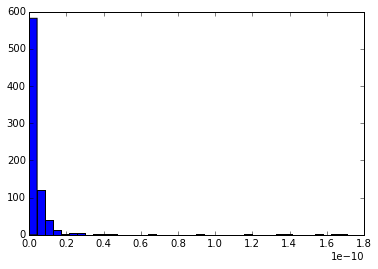

In [17]:
getReconstructPlots(data, times, 'bior1.3', None, 3)

Biorthogonal Wavelet (2.8)

Number detail coefficients zeroed: 657 out of 751
R2 stat: 0.919872098332


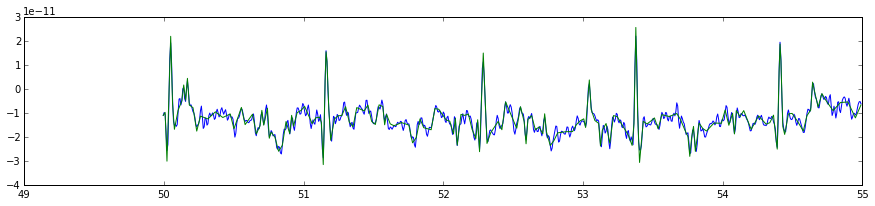

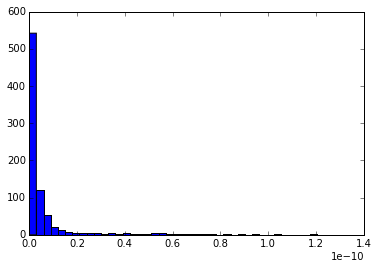

In [18]:
getReconstructPlots(data, times, 'bior2.8', None, 3)

##R^2 Values and Ratio of Zeroed Coefficients

The same reconstruction function was ran over more types of wavelets using 3 and 4 standard deviations as the cutoff, and the results of R^2 and ratio of zeroed coefficients are shown in the tables below.  The function was ran for 10 seconds of EEG and MEG data.

**EEG Data**

| Wavelet Name | R2, 3 SD | R2, 4 SD | Ratio Zeroed, 3 SD | Ratio Zeroed, 4 SD |
|--------------|----------|----------|--------------------|--------------------|
| haar         | 0.8939   | 0.8474   | 0.8890             | 0.9256             |
| db2          | 0.9337   | 0.8971   | 0.8737             | 0.9145             |
| db3          | 0.9507   | 0.9205   | 0.8367             | 0.8848             |
| db5          | 0.9604   | 0.9360   | 0.8200             | 0.8655             |
| db9          | 0.9691   | 0.9472   | 0.7858             | 0.8376             |
| db16         | 0.9752   | 0.9562   | 0.7663             | 0.8154             |
| sym2         | 0.9337   | 0.8971   | 0.8737             | 0.9145             |
| sym3         | 0.9507   | 0.9205   | 0.8367             | 0.8848             |
| sym5         | 0.9535   | 0.9244   | 0.8386             | 0.8879             |
| sym9         | 0.9640   | 0.9375   | 0.8057             | 0.8657             |
| sym16        | 0.9731   | 0.9519   | 0.7651             | 0.8226             |
| coif1        | 0.9355   | 0.8975   | 0.8530             | 0.9005             |
| coif2        | 0.9522   | 0.9224   | 0.8349             | 0.8851             |
| coif3        | 0.9611   | 0.9355   | 0.8076             | 0.8570             |
| coif5        | 0.9682   | 0.9453   | 0.7734             | 0.8269             |
| bior1.3      | 0.8954   | 0.8480   | 0.8809             | 0.9206             |
| bior2.2      | 0.9601   | 0.9330   | 0.8087             | 0.8634             |
| bior2.8      | 0.9695   | 0.9504   | 0.7776             | 0.8351             |
| bior3.1      | 0.9779   | 0.9589   | 0.7138             | 0.7717             |
| bior3.7      | 0.9838   | 0.9720   | 0.7009             | 0.7607             |
| bior6.8      | 0.9737   | 0.9571   | 0.7851             | 0.8351             |
| dmey         | 0.9797   | 0.9634   | 0.7244             | 0.7777             |

**MEG Data**

| Wavelet Name | R2, 3 SD | R2, 4 SD | Ratio Zeroed, 3 SD | Ratio Zeroed, 4 SD |
|--------------|----------|----------|--------------------|--------------------|
| haar         | 0.8333   | 0.7590   | 0.8884             | 0.9236             |
| db2          | 0.8665   | 0.7939   | 0.8770             | 0.9204             |
| db3          | 0.8967   | 0.8448   | 0.8588             | 0.8992             |
| db5          | 0.9048   | 0.8440   | 0.8328             | 0.8840             |
| db9          | 0.9148   | 0.8663   | 0.8107             | 0.8538             |
| db16         | 0.9253   | 0.8741   | 0.7803             | 0.8281             |
| sym2         | 0.8665   | 0.7939   | 0.8770             | 0.9204             |
| sym3         | 0.8967   | 0.8448   | 0.8588             | 0.8992             |
| sym5         | 0.9069   | 0.8447   | 0.8398             | 0.8898             |
| sym9         | 0.9092   | 0.8716   | 0.8426             | 0.8757             |
| sym16        | 0.9406   | 0.8968   | 0.7857             | 0.8396             |
| coif1        | 0.8639   | 0.8046   | 0.8803             | 0.9148             |
| coif2        | 0.8940   | 0.8556   | 0.8578             | 0.8883             |
| coif3        | 0.9098   | 0.8653   | 0.8289             | 0.8688             |
| coif5        | 0.9293   | 0.8873   | 0.7971             | 0.8390             |
| bior1.3      | 0.8319   | 0.7515   | 0.8803             | 0.9258             |
| bior2.2      | 0.9099   | 0.8751   | 0.8360             | 0.8738             |
| bior2.8      | 0.9184   | 0.8766   | 0.8107             | 0.8570             |
| bior3.1      | 0.9537   | 0.9265   | 0.7191             | 0.7658             |
| bior3.7      | 0.9599   | 0.9369   | 0.7091             | 0.7576             |
| bior6.8      | 0.9296   | 0.8878   | 0.8151             | 0.8570             |
| dmey         | 0.9470   | 0.9012   | 0.7450             | 0.7983             |

In addition, the function was ran for the complete EEG data (roughly 280 seconds)

| Wavelet Name | R2, 3 SD | R2, 4 SD | Ratio Zeroed, 3 SD | Ratio Zeroed, 4 SD |
|--------------|----------|----------|--------------------|--------------------|
| haar         | 0.9632   | 0.9458   | 0.8870             | 0.9247             |
| db2          | 0.9790   | 0.9678   | 0.8570             | 0.8980             |
| db3          | 0.9836   | 0.9746   | 0.8443             | 0.8860             |
| db5          | 0.9868   | 0.9787   | 0.8278             | 0.8734             |
| db9          | 0.9889   | 0.9817   | 0.8126             | 0.8607             |
| db16         | 0.9907   | 0.9842   | 0.7973             | 0.8480             |
| sym2         | 0.9790   | 0.9678   | 0.8570             | 0.8980             |
| sym3         | 0.9836   | 0.9746   | 0.8443             | 0.8860             |
| sym5         | 0.9870   | 0.9788   | 0.8264             | 0.8733             |
| sym9         | 0.9894   | 0.9824   | 0.8127             | 0.8606             |
| sym16        | 0.9908   | 0.9844   | 0.8007             | 0.8504             |
| coif1        | 0.9800   | 0.9699   | 0.8553             | 0.8943             |
| coif2        | 0.9862   | 0.9781   | 0.8314             | 0.8746             |
| coif3        | 0.9880   | 0.9807   | 0.8215             | 0.8673             |
| coif5        | 0.9901   | 0.9831   | 0.8055             | 0.8559             |
| bior1.3      | 0.9646   | 0.9489   | 0.8771             | 0.9150             |
| bior2.2      | 0.9886   | 0.9821   | 0.8049             | 0.8519             |
| bior2.8      | 0.9892   | 0.9832   | 0.7955             | 0.8431             |
| bior3.1      | 0.9927   | 0.9881   | 0.7204             | 0.7676             |
| bior3.7      | 0.9946   | 0.9914   | 0.7137             | 0.7648             |
| bior6.8      | 0.9905   | 0.9844   | 0.8007             | 0.8485             |
| dmey         | 0.9928   | 0.9876   | 0.7783             | 0.8293             |